In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['figure.facecolor'] = 'white'

Xdict = {}
Pdict = {}

In [2]:
'''
k-space representation of infinitely thin pressure source 
of finite length (1 / 2 F). So ranges from [-1/F, 1/F]
'''
def phi_finite(kx, ky, F2, l):
    k = np.sqrt(kx * kx + ky * ky)
    pressure = 2. * F2 * np.sin(kx / (2 * F2)) / kx
    pressure[kx == 0] = 1
    return k * pressure / ((kx + l*1.0j) * (kx + l*1.0j) - k)

def calculate_wake(F, l=0.01, kmax=128, d=0.125):
    k = np.arange(-kmax, kmax+d, d)
    n = len(k)
    
    m = (n - 1) / 2
    x = pi / (d * m) * np.arange(-m, m+1, 1)
    
    phi_induced = phi_finite(k[:, None], k[None, :], \
                             np.power(F, 2.0), l)
    
    #Rotate grid since dft starts at zero
    phi_grid = np.roll(phi_induced, -m, axis=0)
    phi_grid = np.roll(phi_grid, -m, axis=1)
    
    fPhi = d*d * np.fft.ifft2(phi_grid)
    fPhi = np.roll(fPhi, m, axis=1)
    fPhi = np.roll(fPhi, m, axis=0)
    fPhi = np.transpose(fPhi)
    
    return x, fPhi

In [3]:
phase = -1.7

def draw_wake_plot(ax, x, phi, bound=None, scale=False):
    r = x[-1]
    stdev = np.std(phi)
    if bound is not None:
        avg = np.average(phi)
        ubound = avg + bound * stdev
        lbound = avg - bound * stdev
        toshow = phi * (phi < ubound) * (phi > lbound)
        toshow[phi > ubound] = ubound
        toshow[phi < lbound] = lbound
    else:
        toshow = phi
        avg = np.average(phi)
        ubound = np.max(toshow[:])
        lbound = np.min(toshow[:])
    if scale:
        toshow -= avg
        toshow = toshow / (ubound - lbound) * 2
        img = plt.imshow(toshow, extent=[-r, r, -r, r], \
                         interpolation='gaussian',
                         vmin=-1, vmax=1)
    else:
        ubound = np.max(toshow[:])
        lbound = np.min(toshow[:])
        rnge = ubound - lbound
        toshow = toshow - lbound - rnge/2
        toshow = toshow / rnge * 2
        img = plt.imshow(toshow, extent=[-r, r, -r, r], \
                         interpolation='gaussian')
    return img

def draw_kelvin_angle(ax, x, color='black'):
    slope = -1. / np.sqrt(8)
    y = np.zeros(x.shape)
    y[0, :] = slope * (x[0, :] - x[0, 1])
    y[1, :] = slope * (x[1, :] - x[1, 1])
    ax.plot(x[0, :], y[0, :], color=color, linestyle=':')
    ax.plot(x[1, :], y[1, :], color=color, linestyle=':')

def draw_inner_angle(ax, x, T, color='black'):
    slope = -np.sqrt(T - 1.) / (2. * T - 1.)
    y = np.zeros(x.shape)
    y[0, :] = slope * (x[0, :] - x[0, 1])
    y[1, :] = slope * (x[1, :] - x[1, 1])
    ax.plot(x[0, :], y[0, :], color=color, linestyle=':')
    ax.plot(x[1, :], y[1, :], color=color, linestyle=':')
    
def draw_parametric_wake(ax, nmax, t, x=[0], color='black', phase=phase):
    t32 = np.power(t, 1.5)
    xtterm = (2*t - 1) / t32
    ytterm = np.sqrt(t - 1) / t32
    for n in range(1, nmax+1):
        t32 = np.power(t, 1.5)
        xt = -np.pi * (2 * n + 1 + phase) * xtterm
        yt = -np.pi * (2 * n + 1 + phase) * ytterm
        for xz in x:
            ax.plot(xt+xz, -yt, color=color, linestyle=':')

def calc_T_value(f, a=1):
    return a * f * f * f * f

In [4]:
def create_large_figure(fig, xdict, pdict, froudes, nrows, ncols, bounds=None, scale=False,
                        kelvin=False, inner=False, parametric=False, xbounds=None, ybounds=None, a=1):
    label = 'a'
    
    for r in range(nrows):
        for c in range(ncols):
            i = r * ncols + c
            ax = fig.add_subplot(nrows, ncols, i+1)
            fr = froudes[i]
            if xbounds is not None:
                ax.set_xlim(xbounds)
            if ybounds is not None:
                ax.set_ylim(ybounds)
            ax.text(0.97, 0.97, 'F=%.2f' % fr, 
                    transform=ax.transAxes,
                    horizontalalignment='right',
                    verticalalignment='top')
            ax.text(0.97, 0.03, label, 
                    transform=ax.transAxes,
                    horizontalalignment='right',
                    verticalalignment='bottom')
            label = chr(ord(label) + 1)
            if bounds is None:
                bound = None
            elif type(bounds) == list:
                bound = bounds[i]
            else:
                bound = bounds
            
            img = draw_wake_plot(ax, xdict[fr], pdict[fr], bound=bound, scale=scale)
            xs = np.zeros([2, 2])
            if xbounds is not None:
                xs[0, 0] = xbounds[0]
                xs[1, 0] = xbounds[0]
            else:
                xs[0, 0] = xdict[fr][0]
                xs[1, 0] = xdict[fr][0]
            xs[0, 1] = -1. / (2 * fr * fr)
            xs[1, 1] = -xs[0, 1]
            
            plt.plot(xs[:, 1], np.zeros(2), color='black', linewidth=2)
            
            if kelvin:                    
                draw_kelvin_angle(ax, xs)
            if inner:
                draw_inner_angle(ax, xs, calc_T_value(froudes[i], a=a), color='black')
            if parametric:
                t = np.linspace(1, 1000, 100000)
                draw_parametric_wake(ax, 12, t, x=xs[:, 1], phase=-1.7)
                
            if c == 0:
                ax.set_ylabel('Y')
            else:
                nlbls = len(ax.get_yticklabels())
                ax.set_yticklabels([''] * nlbls)
            if r == nrows - 1:
                ax.set_xlabel('X')
            else:
                nlbls = len(ax.get_xticklabels())
                ax.set_xticklabels([''] * nlbls)

In [5]:
intFs = [np.sqrt(2), 1., np.sqrt(1./1.8), np.sqrt(1./3.), np.sqrt(1./3.13), 0.5]
morFs = [0.1, 0.2, 0.3, 0.4, 1.5, 1.75, 2.0, 2.5, 3.0]
rn3Fs = [0.22, 0.24, 0.26, 0.28, 0.32, 0.34, 0.36, 0.38, 0.42, 0.44, 0.46, 0.48]

kmax = 128
#kmax = 256
delta = 1. / 8.
delta = 1. / 16.

def generate_wake_patterns(xdict, pdict, fvals, kmax, delta):
    for f in fvals:
        x, p = calculate_wake(f, kmax=kmax, d=delta)
        xdict[f] = np.real(x)
        pdict[f] = np.real(p)
        print('F = %f done' % f)

In [6]:
generate_wake_patterns(Xdict, Pdict, intFs, kmax, delta)

/home/jcolen19/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


F = 1.414214 done
F = 1.000000 done
F = 0.745356 done
F = 0.577350 done
F = 0.565233 done
F = 0.500000 done


In [7]:
generate_wake_patterns(Xdict, Pdict, morFs, kmax, delta)

/home/jcolen19/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


F = 0.100000 done
F = 0.200000 done
F = 0.300000 done
F = 0.400000 done
F = 1.500000 done
F = 1.750000 done
F = 2.000000 done
F = 2.500000 done
F = 3.000000 done


In [8]:
generate_wake_patterns(Xdict, Pdict, rn3Fs, kmax, delta)

/home/jcolen19/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


F = 0.220000 done
F = 0.240000 done
F = 0.260000 done
F = 0.280000 done
F = 0.320000 done
F = 0.340000 done
F = 0.360000 done
F = 0.380000 done
F = 0.420000 done
F = 0.440000 done
F = 0.460000 done
F = 0.480000 done


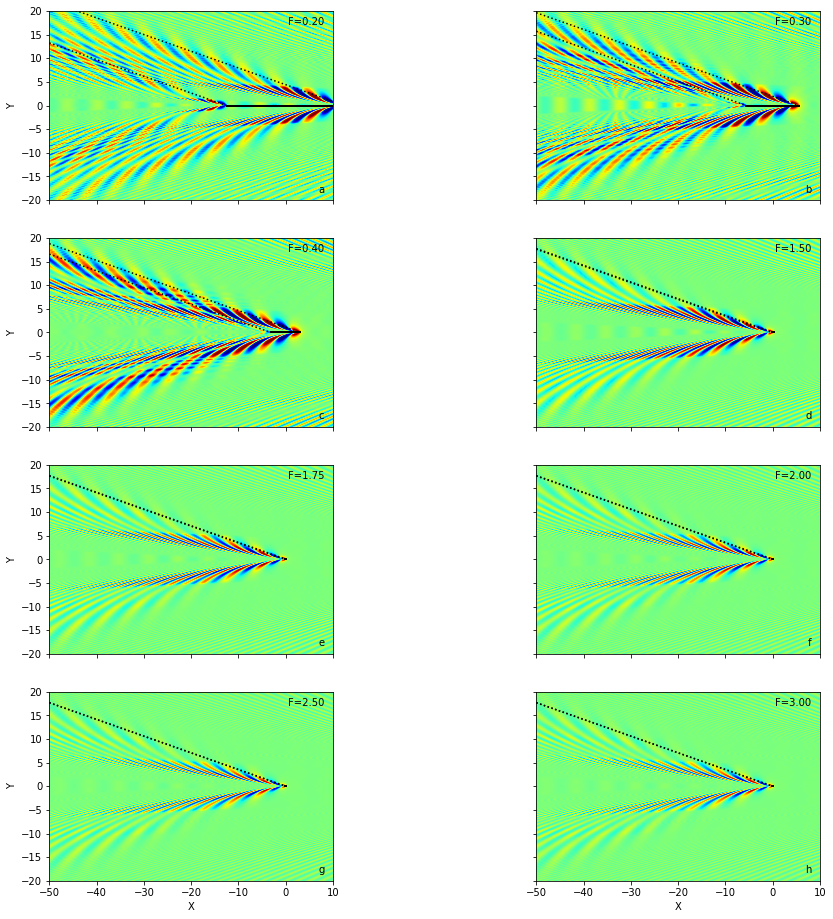

In [9]:
fig = plt.figure(figsize=(16, 16))
create_large_figure(fig, Xdict, Pdict, morFs[1:],
                    4, 2, scale=True, bounds=1, 
                    xbounds = [-50, 10], ybounds=[-20, 20],
                    kelvin=True)

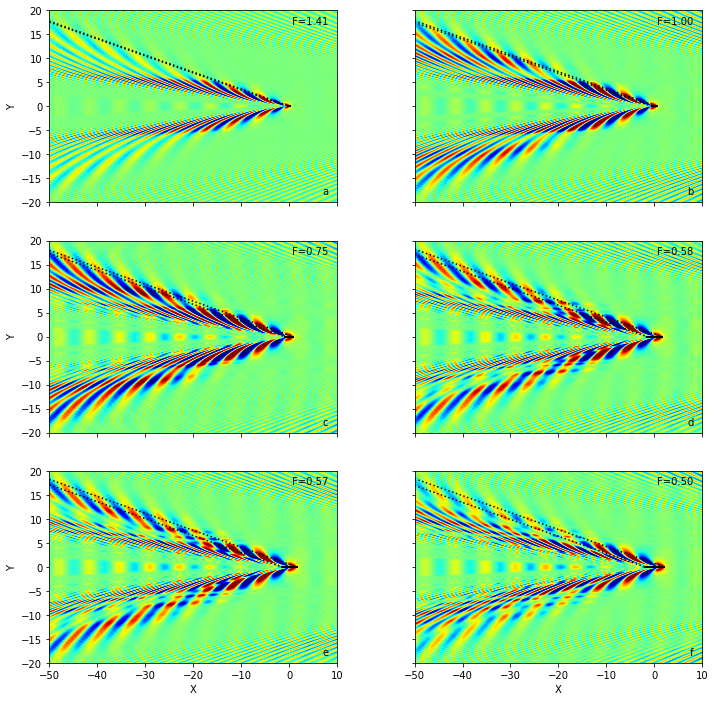

In [10]:
fig = plt.figure(figsize=(12, 12))
create_large_figure(fig, Xdict, Pdict, intFs,
                    3, 2, scale=True, bounds=1, 
                    xbounds = [-50, 10], ybounds=[-20, 20],
                    kelvin=True)

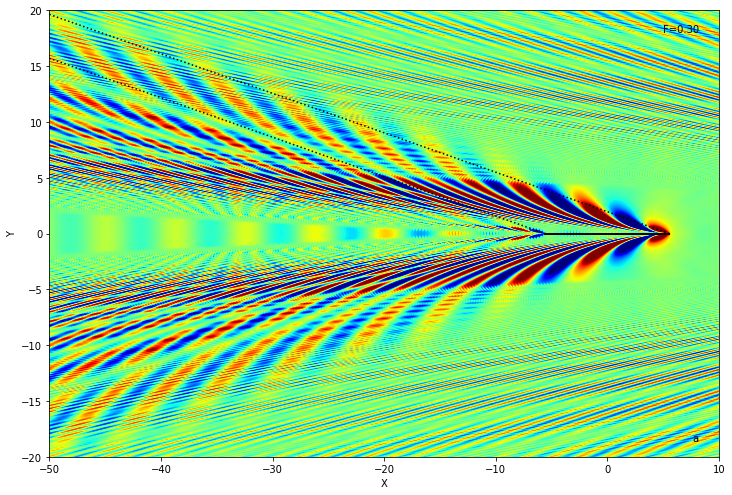

In [11]:
fig = plt.figure(figsize=(12, 12))
create_large_figure(fig, Xdict, Pdict, [0.3],
                    1, 1, scale=True, bounds=1, 
                    xbounds = [-50, 10], ybounds=[-20, 20],
                    kelvin=True)

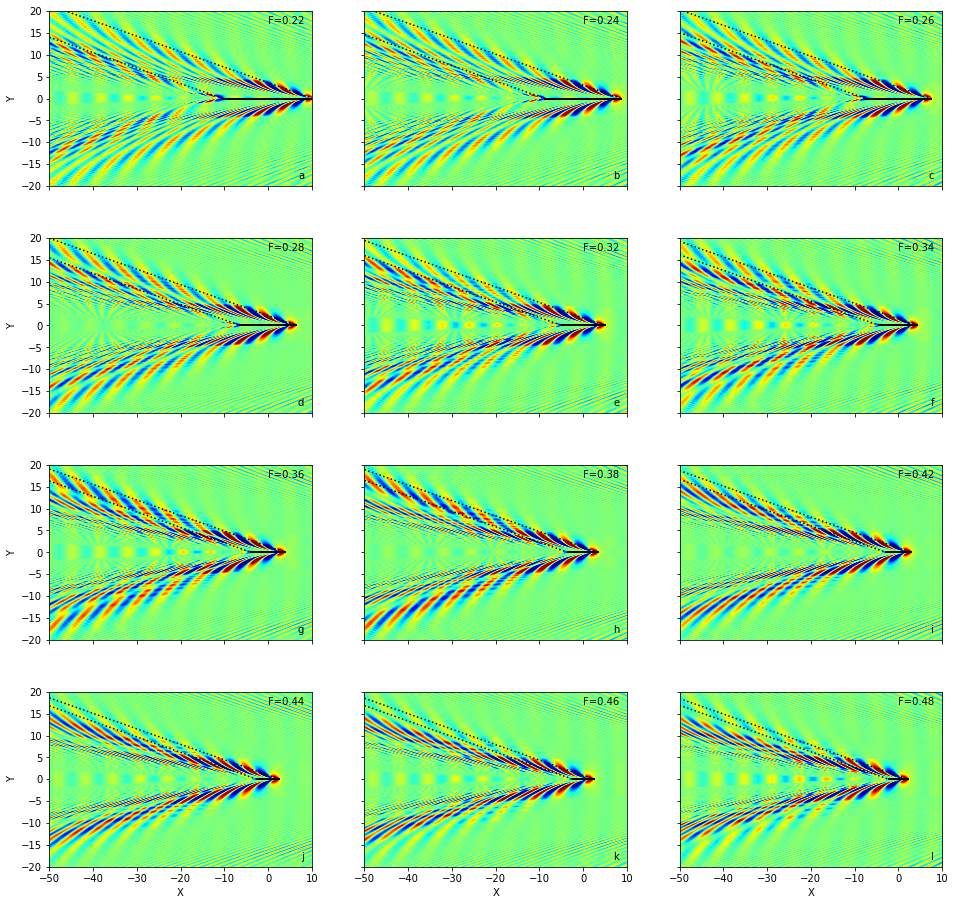

In [13]:
fig = plt.figure(figsize=(16, 16))
create_large_figure(fig, Xdict, Pdict, rn3Fs,
                    4, 3, scale=True, bounds=1, 
                    xbounds = [-50, 10], ybounds=[-20, 20],
                    kelvin=True, parametric=False)